<font color="red" size="6"> Transfer Learning part 2, Fine-Tuning</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
#import helper functions.

from tensorflow_helper import *

This time we're going to see how to use the pre-trained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
train_dir = "../datasets/10_food_classes_10_percent/train/"
test_dir = "../datasets/10_food_classes_10_percent/test/"

tf.random.set_seed(42)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None, #0.2
  seed=42,
  subset=None, #"training"
  image_size=(224, 224),  #Height, width
  batch_size=32,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  validation_split=None, #0.2
  subset=None,   #validation"
  image_size=(224, 224),
  batch_size=32,
  shuffle=True)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
#walk_through_dir("../datasets/10_food_classes_10_percent/")

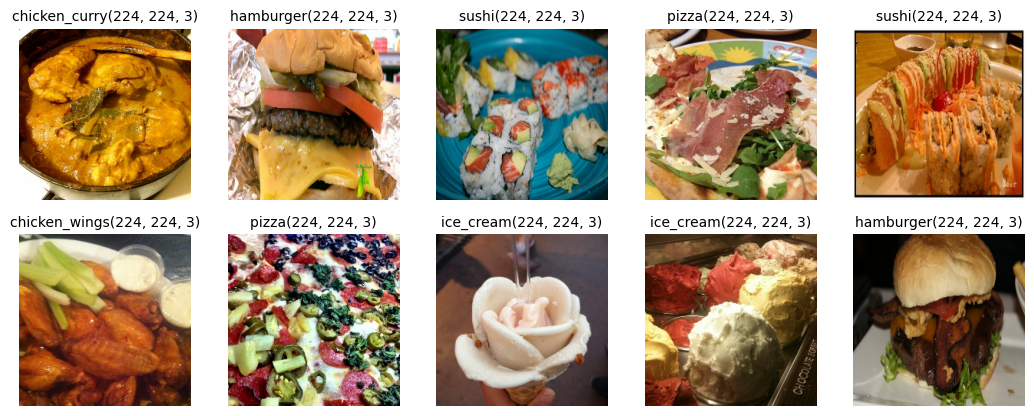

In [4]:
visualize_images_tf_way(train_ds)

### Model 0

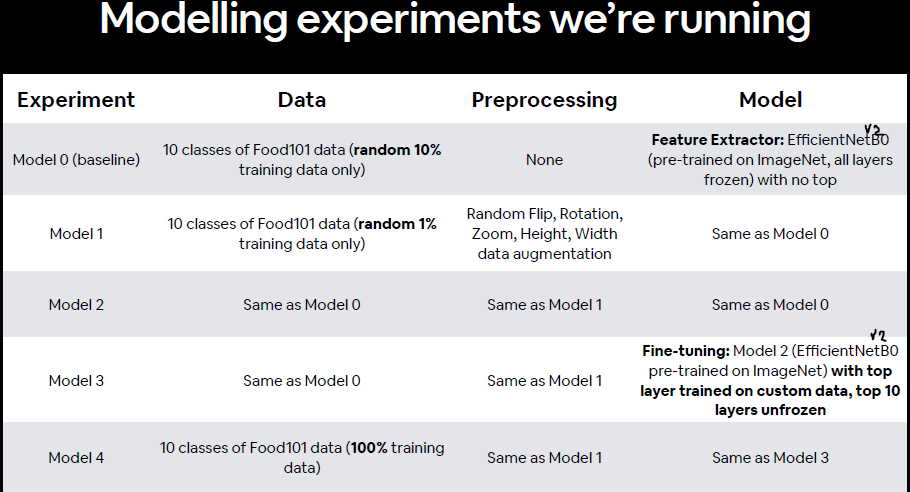

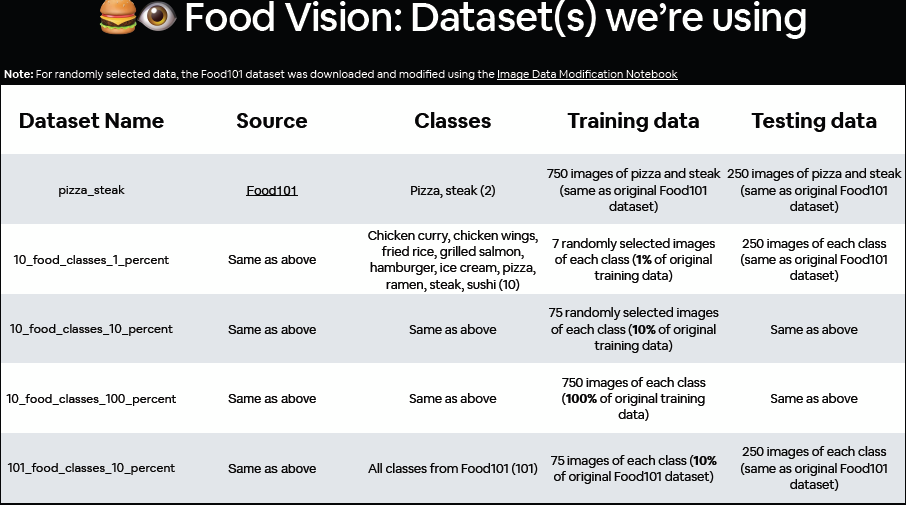

<font color="red">Model 0: Building a transfer learning model using the keras functional API</font>

Functional API gives more flexibility than Sequential API</font>

In [13]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False,
                                                    weights='imagenet',
                                                    input_tensor=None,
                                                    input_shape=None,
                                                    pooling=None,
                                                    classes=1000,
                                                    classifier_activation='softmax',
                                                    include_preprocessing=True)

# 2. Freeze the base model (so the underlying pre-trained patters arent updated)
base_model.trainable = False

#3. Create inputs into out model
inputs = tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")

#4. Some architectures dont have Rescaling included, i would need to add a rescaling layer. 1./255 or 1/127.5 offset -1.
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6.average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layers")(x)
print(f"Shape After GlobalAveragePooling2D: {x.shape}")
      
# 7. Create the output activation layer.
outputs = tf.keras.layers.Dense(10,activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)
      
# 9. COmpile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

# 10 fit the model.
hist = model_0.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
            validation_steps=(0.25 * len(val_ds)), epochs=5, verbose=1,
           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                 experiment_name="10_percent_feature_extraction")])
      

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape After GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220920-223903
Epoch 1/5
24/24 [==============================] - 9s 149ms/step - loss: 1.9960 - accuracy: 0.3227 - val_loss: 1.4020 - val_accuracy: 0.6703
Epoch 2/5
24/24 [==============================] - 2s 98ms/step - loss: 1.2060 - accuracy: 0.7213 - val_loss: 0.9066 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 2s 97ms/step - loss: 0.8643 - accuracy: 0.8040 - val_loss: 0.7222 - val_accuracy: 0.8375
Epoch 4/5
24/24 [==============================] - 2s 98ms/step - loss: 0.6992 - accuracy: 0.8373 - val_loss: 0.6115 - val_accuracy: 0.8578
Epoch 5/5
24/24 [==============================] - 2s 98ms/step - loss: 0.6140 - accuracy: 0.8493 - val_loss: 0.5720 - val_accuracy: 0.8531


,loss,accuracy,val_loss,val_accuracy
0,1.996009,0.322667,1.402032,0.670313
1,1.205976,0.721333,0.906594,0.812500
2,0.864336,0.804000,0.722175,0.837500
3,0.699239,0.837333,0.611454,0.857813
4,0.613987,0.849333,0.571991,0.853125


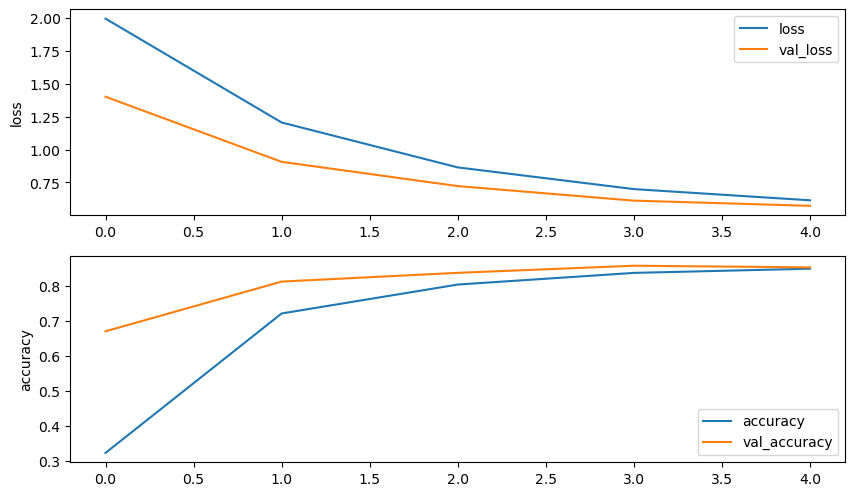

In [29]:
plot_evaluation_curves(hist)

In [6]:
tracker_df = multi_class_models_tracker_df()

In [8]:
X_test, y_test = creating_tests_sets(val_ds,create_x_test=True)

In [9]:
preds_prob = model_0.predict(X_test)
preds = preds_prob.argmax(axis=1)

79/79 [==============================] - 6s 50ms/step


Mathews:  0.844
AUC Score:  0.986


                precision    recall  f1-score   support

 chicken_curry       0.81      0.71      0.75       250
 chicken_wings       0.92      0.80      0.86       250
    fried_rice       0.88      0.88      0.88       250
grilled_salmon       0.68      0.74      0.71       250
     hamburger       0.91      0.92      0.92       250
     ice_cream       0.98      0.94      0.96       250
         pizza       0.95      0.99      0.97       250
         ramen       0.84      0.90      0.87       250
         steak       0.73      0.82      0.78       250
         sushi       0.92      0.87      0.90       250

      accuracy                           0.86      2500
     macro avg       0.86      0.86      0.86      2500
  weighted avg       0.86      0.86      0.86      2500



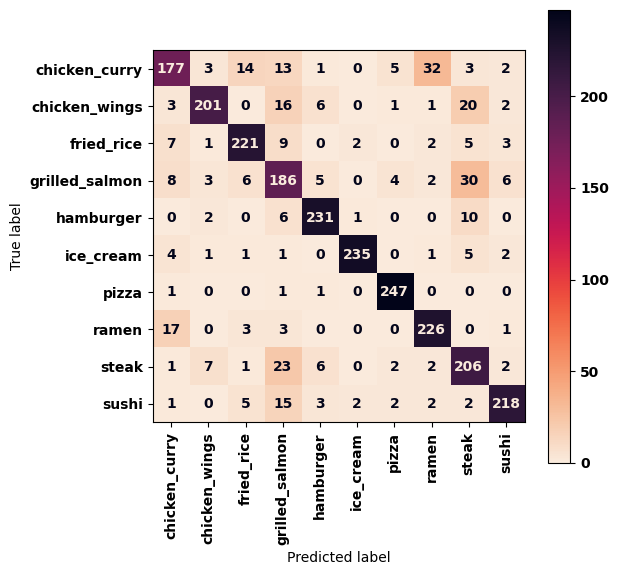

In [33]:
multiclass_report_model(preds, preds_prob, y_test, train_ds.class_names , tracker_df, model_name="model_0", font_size=10)

In [29]:
tracker_df

,model_name,mathews,roc_auc,f1_score,accuracy,recall,precision
0,model_0,0.844,0.987,0.86,0.859,0.859,0.864


In [32]:
# Check the layers of our base model

#for layer_number, layer in enumerate(base_model.layers):
    #print(layer_number, layer.name)

In [34]:
#base_model.summary()

In [35]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


## <font color="red" size="5">Getting a Feature Vector From a trained model</font>



let's demostrate the global average Pooling 2d layer..

We have a tensor after out model goes throught "base_model" of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [55]:
# Define the input shape
input_shape = (1, 4, 4, 3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)

In [60]:
input_tensor.shape

TensorShape([1, 4, 4, 3])

In [56]:
#Pass the random tensor into a globalaveragepooling2d layer., removes inner dimensions.

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [61]:
tf.math.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [57]:
tf.math.reduce_mean(input_tensor[:,:,:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.09368648>

In [58]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [62]:
tf.math.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [59]:
tf.math.reduce_max(input_tensor[:,:,:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.9058464>

## Model_1

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [6]:
# Download and unzip data
#!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
#unzip_datas("10_food_classes_1_percent.zip", path="../datasets/10_food_classes_1_percent")

# Create training and test dirs
train_dir_1_percent = "../datasets/10_food_classes_1_percent/train/"
test_dir = "../datasets/10_food_classes_1_percent/test/"

In [7]:
tf.random.set_seed(42)
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir_1_percent,
  validation_split=None, #0.2
  seed=42,
  subset=None, #"training"
  image_size=IMAGE_SIZE,  #Height, width
  batch_size=BATCH_SIZE,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  validation_split=None, #0.2
  subset=None,   #validation"
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
## Adding data augmentation as layers to our model.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    #tf.keras.layers.RandomBrightness(factor=[-0.1,0.1]),
    #tf.keras.layers.RandomContrast(0.2),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    #tf.keras.layers.Rescaling(1./255)
    ],
    name="data_augmentation")


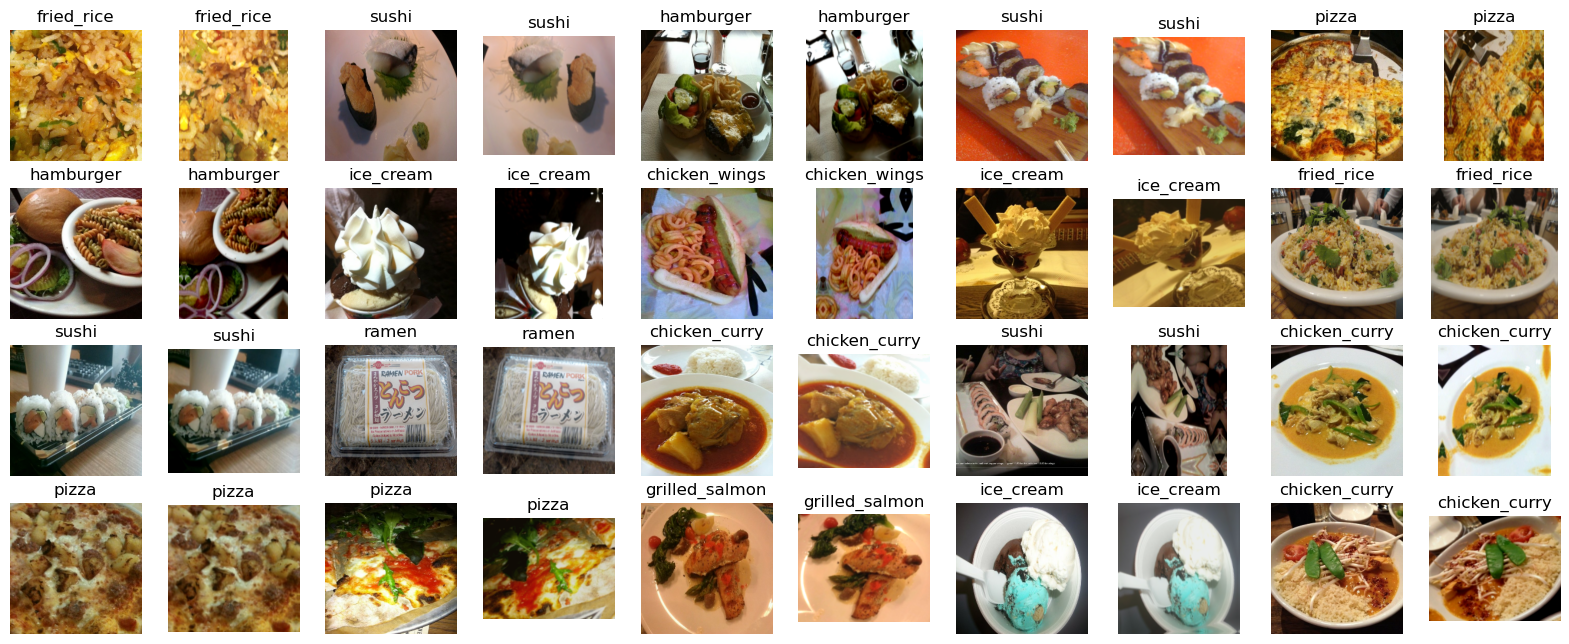

In [9]:
visualize_images_tf_way_augmented(train_ds)

<font color="blue"> Model 1 </font>

In [16]:
# Setup the input shape and base model. freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") #Inputs
x = data_augmentation(inputs)               # Add data augmentation
x = base_model(x,training=False)          #Give base_model the inputs after augmentation.
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d")(x) # Pool output features of the base model.
outputs = tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax", name="output_layer")(x)  #Dense layer as output

model_1 = tf.keras.Model(inputs,outputs)  #Make the model

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model_1.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds, validation_steps=(0.25 * len(val_ds)), 
           epochs=5, verbose=1, callbacks=create_tensorboard_callback("transfer_learning", "1percent_experiment_aug"))


Saving TensorBoard log files to: transfer_learning/1percent_experiment_aug/20220918-184918
Epoch 1/5
3/3 [==============================] - 8s 1s/step - loss: 2.4066 - accuracy: 0.1143 - val_loss: 2.2032 - val_accuracy: 0.1750
Epoch 2/5
3/3 [==============================] - 1s 609ms/step - loss: 2.1477 - accuracy: 0.2000 - val_loss: 2.0702 - val_accuracy: 0.2953
Epoch 3/5
3/3 [==============================] - 1s 589ms/step - loss: 1.9715 - accuracy: 0.2571 - val_loss: 1.9655 - val_accuracy: 0.3438
Epoch 4/5
3/3 [==============================] - 1s 596ms/step - loss: 1.8012 - accuracy: 0.4857 - val_loss: 1.8609 - val_accuracy: 0.4125
Epoch 5/5
3/3 [==============================] - 1s 611ms/step - loss: 1.6090 - accuracy: 0.6714 - val_loss: 1.7999 - val_accuracy: 0.4344


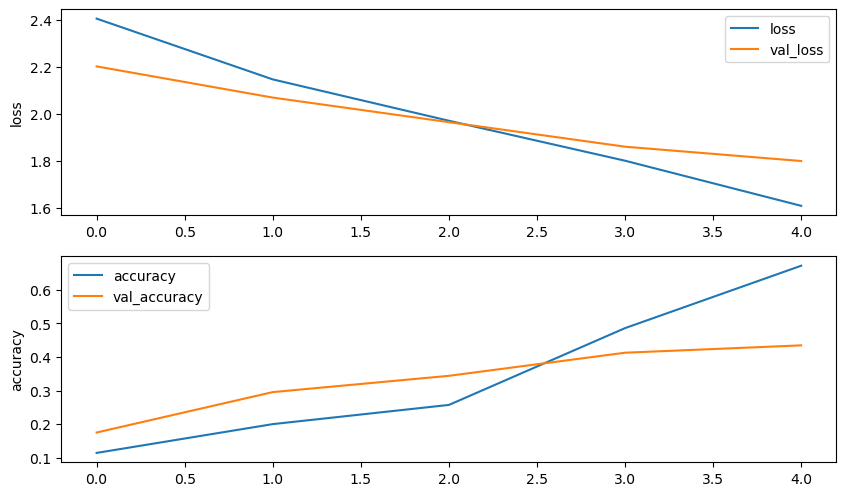

In [17]:
history = plot_evaluation_curves(model_1)

In [24]:
X_test, y_test = creating_tests_sets(val_ds)

In [25]:
def predictions_and_probs_multiclass(model, X_test):
    preds_prob = model.predict(X_test)
    preds = preds_prob.argmax(axis=1)
    
    return preds, preds_prob

In [26]:
preds, preds_prob = preds_and_probs_multiclass(model_1, X_test)

79/79 [==============================] - 5s 45ms/step


In [27]:
tracker_df = multi_class_models_tracker_df

Mathews:  0.394
AUC Score:  0.868


                precision    recall  f1-score   support

 chicken_curry       0.43      0.37      0.40       250
 chicken_wings       0.28      0.47      0.35       250
    fried_rice       0.83      0.64      0.73       250
grilled_salmon       0.20      0.48      0.29       250
     hamburger       0.39      0.26      0.31       250
     ice_cream       0.91      0.50      0.64       250
         pizza       0.85      0.68      0.76       250
         ramen       0.66      0.38      0.48       250
         steak       0.36      0.50      0.42       250
         sushi       0.56      0.20      0.29       250

      accuracy                           0.45      2500
     macro avg       0.55      0.45      0.47      2500
  weighted avg       0.55      0.45      0.47      2500



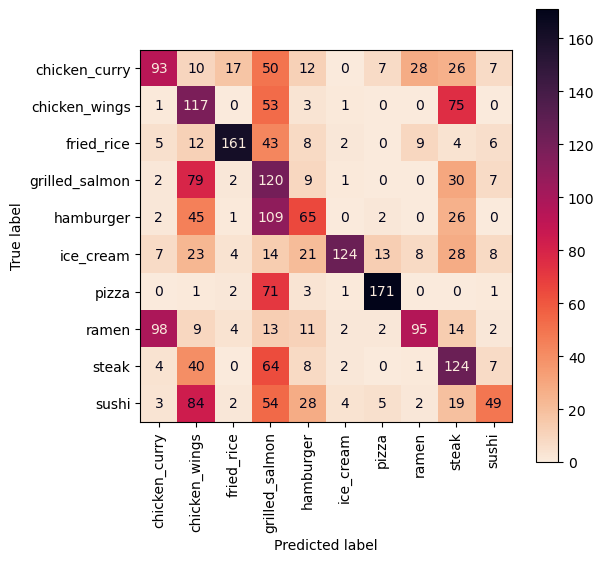

In [28]:
multiclass_report_model(preds, preds_prob, y_test, val_ds.class_names, tracker_df=tracker_df, model_name="1percent_model_1")

## Model_2

In [28]:
train_dir = "../datasets/10_food_classes_10_percent/train/"
test_dir = "../datasets/10_food_classes_10_percent/test/"

tf.random.set_seed(42)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None, #0.2
  seed=42,
  subset=None, #"training"
  image_size=(224, 224),  #Height, width
  batch_size=32,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  validation_split=None, #0.2
  subset=None,   #validation"
  image_size=(224, 224),
  batch_size=32,
  shuffle=True)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
## Adding data augmentation as layers to our model.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    #tf.keras.layers.RandomBrightness(factor=[-0.1,0.1]),
    #tf.keras.layers.RandomContrast(0.2),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    #tf.keras.layers.Rescaling(1./255)
    ],
    name="data_augmentation")

<font color="blue"> Create ModelCheckpoint Callback</font>

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains. 

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [30]:
checkpoint_path = "weights_checkpoints/checkpoint_aug_model_2/CP"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                        ,verbose=1, save_freq="epoch")

In [32]:
# Setup the input shape and base model. freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") #Inputs
x = data_augmentation(inputs)               # Add data augmentation
x = base_model(x,training=False)          #Give base_model the inputs after augmentation, makes sure batchnorm layers doesnt change
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d")(x) # Pool output features of the base model.
outputs = tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax", name="output_layer")(x)  #Dense layer as output

model_2 = tf.keras.Model(inputs,outputs)  #Make the model

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

inital_epochs = 5

history_10_percent_data_aug = model_2.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                                          validation_steps=(0.25 * len(val_ds)), 
           epochs=inital_epochs, verbose=1, callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_experiment_aug_model_2"),
                                           checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_experiment_aug_model_2/20220919-151111
Epoch 1/5
23/24 [===========================>..] - ETA: 0s - loss: 2.0018 - accuracy: 0.3478
Epoch 1: val_loss improved from inf to 1.49227, saving model to weights_checkpoints/checkpoint_aug_model_2\CP
24/24 [==============================] - 10s 184ms/step - loss: 1.9976 - accuracy: 0.3507 - val_loss: 1.4923 - val_accuracy: 0.6625
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.4075 - accuracy: 0.6535
Epoch 2: val_loss improved from 1.49227 to 1.05710, saving model to weights_checkpoints/checkpoint_aug_model_2\CP
24/24 [==============================] - 3s 126ms/step - loss: 1.4068 - accuracy: 0.6533 - val_loss: 1.0571 - val_accuracy: 0.7500
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 1.1336 - accuracy: 0.7160
Epoch 3: val_loss improved from 1.05710 to 0.84391, saving model to weights_checkpoints/checkpoint_aug_model_2\CP
24/24 [============

,loss,accuracy,val_loss,val_accuracy
0,1.997564,0.350667,1.492265,0.662500
1,1.406811,0.653333,1.057100,0.750000
2,1.129881,0.718667,0.843906,0.789062
3,0.941671,0.757333,0.722855,0.817187
4,0.827819,0.786667,0.668120,0.823438


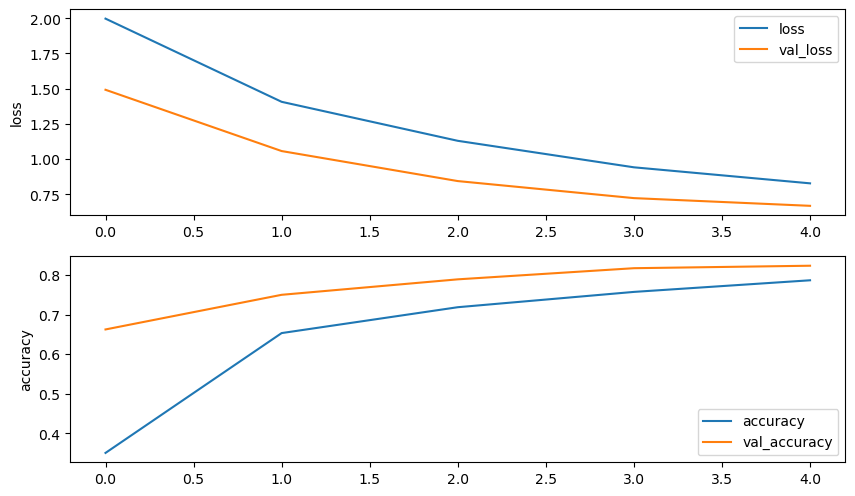

In [34]:
plot_evaluation_curves(model_2)

<font color="blue" size="6">Loading in Checkpointed weights</font>

Loading in checkpointed weights return a model to a specific checkpoint.

In [35]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [36]:
loaded_weights_model_results = model_2.evaluate(val_ds)

79/79 [==============================] - 4s 51ms/step - loss: 0.6639 - accuracy: 0.8232


## Model 3

<font color="blue"> Fine-tuning an existing model on 10% of the data.</font>

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

In [37]:
# Load in saved model weights and evaluate model
checkpoint_path = "weights_checkpoints/checkpoint_aug_model_2/CP"
model_2.load_weights(checkpoint_path)

model_3 = model_2

In [38]:
#Layers in trained model

model_3.layers

In [39]:
# Are this layers trainable?
for layer in model_3.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001157B4ED0D0> True
<keras.engine.sequential.Sequential object at 0x000001157209A250> True
<keras.engine.functional.Functional object at 0x000001157B4AF1C0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000011571E27310> True
<keras.layers.core.dense.Dense object at 0x000001157A3F9FA0> True


In [40]:
# what layers are in out base model (EfficientNetv2B0) and are they trainable?

for i, layer in enumerate(model_3.layers[2].layers):
    #print(i, layer.name, layer.trainable)
    pass

In [41]:
# how many trainable variables are in our base model?
len(model_3.layers[2].trainable_variables)

0

In [42]:
# to begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False


# Recompile (we have to recompile our models everytime we make a change)
# I should make a very low learning rate when i start fine-tuning, thumb rule. lower lr by 10x.
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])


> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

In [43]:
# how many trainable variables are in our base model?
len(model_3.layers[2].trainable_variables)

10

In [44]:
checkpoint_path = "weights_checkpoints/checkpoint_fine_tune_model_3/CP"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                        ,verbose=1, save_freq="epoch")

In [45]:
in_epoch = history_10_percent_data_aug.epoch[-1] # start training from previous last epoch.
fine_tune_epochs = inital_epochs + 5

hist_fine_10_perc_mod_3 = model_3.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds, 
                                      validation_steps=(0.25 * len(val_ds)), 
           epochs=fine_tune_epochs, initial_epoch=in_epoch,  verbose=1, 
            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_experiment_fine_tune_mod3"),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_experiment_fine_tune_mod3/20220919-151158
Epoch 5/10
23/24 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.8166
Epoch 5: val_loss improved from inf to 0.52422, saving model to weights_checkpoints/checkpoint_fine_tune_model_3\CP
24/24 [==============================] - 10s 184ms/step - loss: 0.6968 - accuracy: 0.8147 - val_loss: 0.5242 - val_accuracy: 0.8219
Epoch 6/10
23/24 [===========================>..] - ETA: 0s - loss: 0.5905 - accuracy: 0.8288
Epoch 6: val_loss improved from 0.52422 to 0.49199, saving model to weights_checkpoints/checkpoint_fine_tune_model_3\CP
24/24 [==============================] - 3s 132ms/step - loss: 0.5883 - accuracy: 0.8307 - val_loss: 0.4920 - val_accuracy: 0.8328
Epoch 7/10
23/24 [===========================>..] - ETA: 0s - loss: 0.5415 - accuracy: 0.8193
Epoch 7: val_loss improved from 0.49199 to 0.45915, saving model to weights_checkpoints/checkpoint_fine_tune_model_

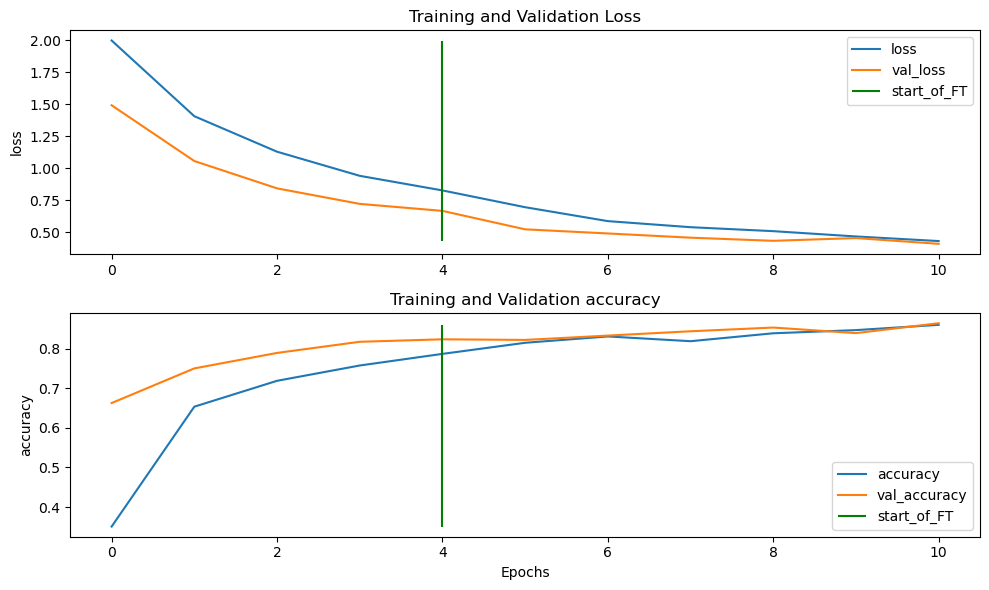

In [46]:
total_hist = plot_evaluation_curves_fine_tune(history_10_percent_data_aug,hist_fine_10_perc_mod_3)

## Model 4

In [3]:
train_dir = "../datasets/10_food_classes_all_data/train/"
test_dir = "../datasets/10_food_classes_all_data/test/"

tf.random.set_seed(42)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None, #0.2
  seed=42,
  subset=None, #"training"
  image_size=(224, 224),  #Height, width
  batch_size=32,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  validation_split=None, #0.2
  subset=None,   #validation"
  image_size=(224, 224),
  batch_size=32,
  shuffle=True)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
## Adding data augmentation as layers to our model.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    #tf.keras.layers.RandomBrightness(factor=[-0.1,0.1]),
    #tf.keras.layers.RandomContrast(0.2),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    #tf.keras.layers.Rescaling(1./255)
    ],
    name="data_augmentation")

In [10]:
checkpoint_path = "weights_checkpoints/checkpoint_model_4/CP"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                        ,verbose=1, save_freq="epoch")

In [11]:
# Setup the input shape and base model. freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") #Inputs
x = data_augmentation(inputs)               # Add data augmentation
x = base_model(x,training=False)          #Give base_model the inputs after augmentation, makes sure batchnorm layers doesnt change
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d")(x) # Pool output features of the base model.
outputs = tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax", name="output_layer")(x)  #Dense layer as output

model_4 = tf.keras.Model(inputs,outputs)  #Make the model

model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

in_epoch = 5

model_4_all_perc_history = model_4.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                                          validation_steps=(len(val_ds)), 
           epochs=in_epoch, verbose=1, callbacks=[create_tensorboard_callback("transfer_learning", "all_perc_experiment_model_4"),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/all_perc_experiment_model_4/20220919-161118
Epoch 1/5
234/235 [============================>.] - ETA: 0s - loss: 1.1186 - accuracy: 0.6688
Epoch 1: val_loss improved from inf to 0.47301, saving model to weights_checkpoints/checkpoint_fine_tune_100perc_model_4\CP
235/235 [==============================] - 28s 95ms/step - loss: 1.1183 - accuracy: 0.6689 - val_loss: 0.4730 - val_accuracy: 0.8728
Epoch 2/5
234/235 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.7863
Epoch 2: val_loss improved from 0.47301 to 0.37694, saving model to weights_checkpoints/checkpoint_fine_tune_100perc_model_4\CP
235/235 [==============================] - 21s 90ms/step - loss: 0.6855 - accuracy: 0.7865 - val_loss: 0.3769 - val_accuracy: 0.8872
Epoch 3/5
234/235 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.8177
Epoch 3: val_loss improved from 0.37694 to 0.34318, saving model to weights_checkpoints/checkpoint_fin

In [19]:
# Seeing model variables, and seeing if they are trainable or not
for i, layer in enumerate(model_4.layers[2].layers):
    #print(i, layer.name, layer.trainable)
    pass

In [21]:
# to begin fine-tuning, let's start by setting the last 18 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all layers except for the last 18
for layer in base_model.layers[:-18]:
    layer.trainable = False


# Recompile (we have to recompile our models everytime we make a change)
# I should make a very low learning rate when i start fine-tuning, thumb rule. lower lr by 10x.
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

In [22]:
# how many trainable variables are in our base model?
len(model_4.layers[2].trainable_variables)

16

In [23]:
checkpoint_path = "weights_checkpoints/checkpoint_model_4/CP"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                        ,verbose=1, save_freq="epoch")

In [25]:
in_epoch = model_4_all_perc_history.epoch[-1] # start training from previous last epoch.
fine_tune_epochs = in_epoch + 10

model_4_fine_tune_all_perc_history = model_4.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds, 
                                      validation_steps=(len(val_ds)), 
           epochs=fine_tune_epochs, initial_epoch=in_epoch,  verbose=1, 
            callbacks=[create_tensorboard_callback("transfer_learning", "all_perc_experiment_model_4_fine_tune_1"),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/all_perc_experiment_model_4_fine_tune_1/20220919-161558
Epoch 5/14
235/235 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8396
Epoch 5: val_loss improved from inf to 0.27594, saving model to weights_checkpoints/checkpoint_fine_tune_100perc_model_4\CP
235/235 [==============================] - 30s 103ms/step - loss: 0.4836 - accuracy: 0.8396 - val_loss: 0.2759 - val_accuracy: 0.9084
Epoch 6/14
235/235 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8593
Epoch 6: val_loss improved from 0.27594 to 0.27073, saving model to weights_checkpoints/checkpoint_fine_tune_100perc_model_4\CP
235/235 [==============================] - 22s 94ms/step - loss: 0.4262 - accuracy: 0.8593 - val_loss: 0.2707 - val_accuracy: 0.9064
Epoch 7/14
234/235 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8669
Epoch 7: val_loss improved from 0.27073 to 0.24844, saving model to weights_checkpoint

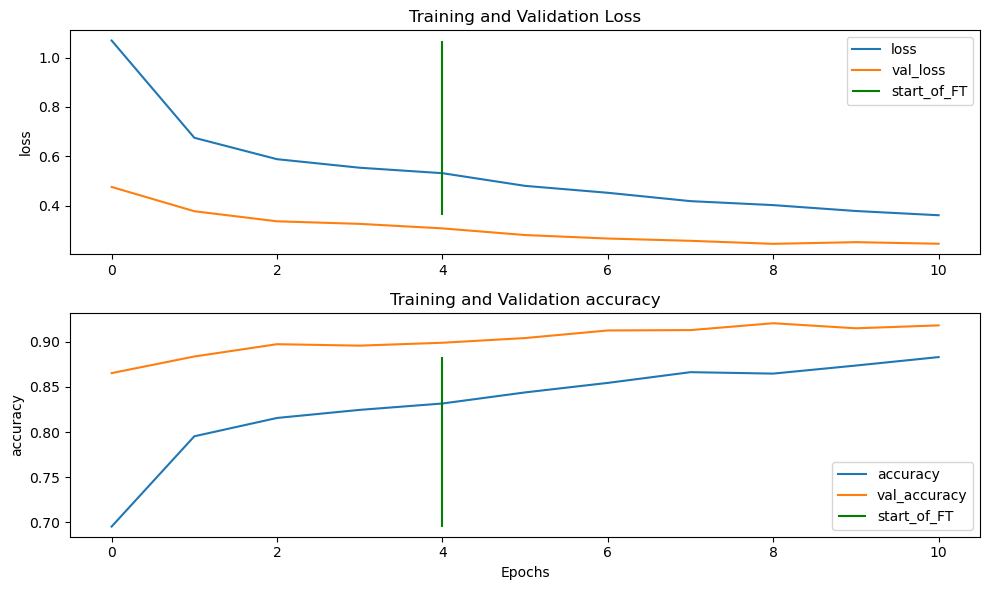

In [74]:
hist = plot_evaluation_curves_fine_tune(model_4_all_perc_history, model_4_fine_tune_all_perc_history)

1/1 [==============================] - 2s 2s/step


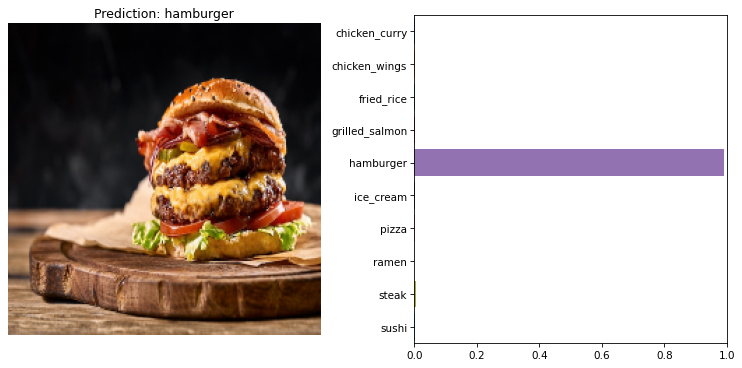

In [44]:
multiclass_pred_new_image(model_4, "juicy_burger.jpg", train_ds.class_names)

## Model_5

In [6]:
## Adding data augmentation as layers to our model.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    #tf.keras.layers.RandomBrightness(factor=[-0.1,0.1]),
    #tf.keras.layers.RandomContrast(0.2),
    #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    #tf.keras.layers.Rescaling(1./255)
    ],
    name="data_augmentation")

In [7]:
checkpoint_path = "weights_checkpoints/checkpoint_model_5/CP"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                        ,verbose=1, save_freq="epoch")

In [8]:
# Setup the input shape and base model. freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") #Inputs
x = data_augmentation(inputs)               # Add data augmentation
x = base_model(x,training=False)          #Give base_model the inputs after augmentation, makes sure batchnorm layers doesnt change
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d")(x) # Pool output features of the base model.
outputs = tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax", name="output_layer")(x)  #Dense layer as output

model_5 = tf.keras.Model(inputs,outputs)  #Make the model

model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

in_epoch = 15

model_5_all_perc_history = model_5.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                                          validation_steps=(len(val_ds)), 
           epochs=in_epoch, verbose=1, callbacks=[create_tensorboard_callback("transfer_learning", "all_perc_experiment_model_5"),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/all_perc_experiment_model_5/20220919-160341
Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.6955
Epoch 1: val_loss improved from inf to 0.47585, saving model to weights_checkpoints/checkpoint_model_5\CP
235/235 [==============================] - 46s 166ms/step - loss: 1.0689 - accuracy: 0.6955 - val_loss: 0.4759 - val_accuracy: 0.8652
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.7953
Epoch 2: val_loss improved from 0.47585 to 0.37753, saving model to weights_checkpoints/checkpoint_model_5\CP
235/235 [==============================] - 23s 97ms/step - loss: 0.6750 - accuracy: 0.7953 - val_loss: 0.3775 - val_accuracy: 0.8836
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.8156
Epoch 3: val_loss improved from 0.37753 to 0.33672, saving model to weights_checkpoints/checkpoint_model_5\CP
235/235 [===============

## Tensorboard

In [40]:
#%load_ext tensorboard
#%tensorboard --port=6007 --logdir ./transfer_learning/

In [41]:
!taskkill /IM "tensorboard.exe" /F

SUCCESS: The process "tensorboard.exe" with PID 3128 has been terminated.


In [42]:
import tempfile
import os
import shutil 
path = os.path.join(tempfile.gettempdir(), ".tensorboard-info") 
shutil.rmtree(path) ##this removes the folder recursively
